# **Analysis of the role of attention and prompt engineering in decoder-only transformers logical reasoning**

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("src")
from data_loading import *
from analysis_utils import *


RESULTS_FOLDER = "results"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

### Dataset downloading

In [2]:
DATASET_PATH = "dataset"

if not os.path.isdir(DATASET_PATH):
    !wget -nc -P . https://allenai.org/data/proofwriter
    !unzip -q -d . proofwriter
    !mv proofwriter-dataset-V2020.12.3 $DATASET_PATH
    !rm proofwriter

### Dataset loading

In [3]:
dataset = ProofWriterDataset(None, DATASET_PATH + "/OWA/depth-3/meta-train.jsonl", triple_label="t", rule_label="r")
examples_dataset = ProofWriterDataset(None, DATASET_PATH + "/OWA/depth-3/meta-dev.jsonl", triple_label="t", rule_label="r")

### Model loading

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.random.manual_seed(0)

model_name = "mistralai/Mistral-7B-Instruct-v0.3"

bnb_config = BitsAndBytesConfig(
    # load_in_4bit=True,
    # bnb_4bit_compute_dtype="float16",
    # bnb_4bit_use_double_quant=True,
    # bnb_4bit_quant_type="nf4"
    load_in_8bit=True,
    bnb_8bit_compute_dtype="float16",
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf8"
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    # torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = "eos_token_id"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Execution

In [44]:
def text_generation_and_attention_analysis(prompts, y_true, proofs, model, tokenizer, experiment_name, results_folder="results"):

    y_pred = []
    mean_attention_per_group_last_layer = pd.DataFrame(columns=list(prompts[0][1].keys()) + ["correct_prediction"], dtype=np.float64)
    proofs_metrics = pd.DataFrame(columns=["auc", "auprc", "correct_prediction"], dtype=np.float64)

    generation_args = {
        "output_attentions" : True,
        "return_dict_in_generate": True,
        "max_new_tokens": 100,
        "do_sample": False,
        "pad_token_id": tokenizer.eos_token_id
    }

    for i, (prompt, prompt_segmentation, theory_segmentation, tuples_and_rules) in tqdm(enumerate(prompts), total=len(prompts)):

        encoded = tokenizer(
            prompt,
            return_offsets_mapping=True,
            return_tensors="pt",
            padding=True
        )

        offset_mapping = encoded.pop("offset_mapping")
        encoded = encoded.to("cuda")

        with torch.no_grad():
            outputs = model.generate(**encoded, **generation_args)
        
        generated_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)[len(prompt):]
        
        # print(prompt)
        # print("----")
        # print(generated_text)

        res = re.findall(fr"<final>([\s\S]*?)</final>", generated_text)[0]

        y_pred.append(str_bool_to_bin(res))
        correct_prediction = int(y_true[i] == str_bool_to_bin(res))

        offsets = offset_mapping[0]
        groups_delimiters_by_characters = reduce(lambda acc, x : acc + [x[1]], prompt_segmentation.values(), [0])
        groups_intervals_by_token = get_groups_delimiter_intervals_by_tokens(groups_delimiters_by_characters, offsets)
        n_input_tokens = groups_intervals_by_token[-1][-1]

        # print([layer[i].detach().to(torch.float32).cpu().numpy() for layer in outputs.attentions])

        prompt_length = encoded["input_ids"].shape[-1]
        new_token_ids = outputs.sequences[0][prompt_length:]
        tokens = tokenizer.convert_ids_to_tokens(new_token_ids)
        non_special_tokens = [t for t in tokens if not tokenizer.special_tokens_map.get(t) and t not in tokenizer.all_special_tokens]
        # print(f"Non special tokens generated: {len(non_special_tokens)}")

        print(theory_segmentation)

        means = []
        
        for k, attn_gen_token in enumerate(outputs.attentions):
            if k == 0: continue # attention map only referred to input tokens
            if k == len(non_special_tokens)+1: break

            means.append(np.mean([head[0][:n_input_tokens] for head in attn_gen_token[0][0].detach().to(torch.float32).cpu().numpy()], axis=0))

        mean_output_attention = np.mean(means, axis=0)

        groups_mean_attention = np.zeros((1, len(prompt_segmentation)))

        for j, (start, end) in enumerate(groups_intervals_by_token):
            values = mean_output_attention[start:end]
            
            try:
                groups_mean_attention[0][j] = np.mean(values)
            except: print(mean_output_attention[start:end], start, end)

        # [l.append(groups_mean_attention[0][j]) for j, l in enumerate(mean_attention_per_group_last_layer)]

        mean_attention_per_group_last_layer = pd.concat([mean_attention_per_group_last_layer, pd.DataFrame([list(groups_mean_attention[0]) + [correct_prediction]], columns= list(prompt_segmentation.keys()) + ["correct_prediction"])], ignore_index=True)
        
        theory_intervals_by_token = dict(zip(tuples_and_rules, get_groups_delimiter_intervals_by_tokens(theory_segmentation, offsets)))

        mean_attention_on_theory_components = dict(zip(tuples_and_rules, np.zeros(len(theory_intervals_by_token))))
        
        for key, (start, end) in theory_intervals_by_token.items():
            values = mean_output_attention[start:end]
            mean_attention_on_theory_components[key] = np.mean(values)
            
        
        actual_proof_terms = set(find_stmt_names(proofs[i]))

        from sklearn.metrics import roc_auc_score, average_precision_score

        stmt_labels = [1 if stmt_name in actual_proof_terms else 0 for stmt_name in tuples_and_rules]
        
        auc, auprc = 0, 0
        try:
            auc = roc_auc_score(stmt_labels, list(mean_attention_on_theory_components.values()))
            auprc = average_precision_score(stmt_labels, list(mean_attention_on_theory_components.values()))
        except: pass

        proofs_metrics = pd.concat([proofs_metrics, pd.DataFrame([[auc, auprc, correct_prediction]], columns=proofs_metrics.columns)], ignore_index=True)
        
        """plt.figure(figsize=(20, 1))
        hm = sns.heatmap(groups_mean_attention, xticklabels=list(prompt_segmentation.keys()), yticklabels=["output"], cmap="summer", annot=True)
        hm.set_xticklabels(hm.get_xticklabels(), rotation=30, ha="right")
        plt.title("Mean attention from output tokens to input groups of tokens")
        plt.xticks(rotation=30)
        plt.show()

        plt.figure(figsize=(20, 1))
        hm = sns.heatmap(mean_attention_on_theory_components.values(), xticklabels=list([prompt[theory_segmentation[i] : theory_segmentation[i+1]] for i in range(len(theory_segmentation)-1)]), yticklabels=["output"], cmap="summer", annot=True)
        hm.set_xticklabels(hm.get_xticklabels(), rotation=30, ha="right")
        plt.title("Mean attention from output tokens to groups of tokens of the theory")
        plt.show()"""
        
        del outputs, encoded
        torch.cuda.empty_cache()

    compute_performance(y_true, y_pred)

    plt.figure(figsize=(6, 5))

    x_name, y_name = "groups of tokens", "average attention"
    long_df = mean_attention_per_group_last_layer.melt(var_name=x_name, value_name=y_name, id_vars="correct_prediction")

    sns.boxplot(x=x_name, y=y_name, data=long_df, hue="correct_prediction", hue_order=[1, 0], palette=["#1A85FF", "#D41159"], width=.5)

    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ["correct prediction", "incorrect prediction"])
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    os.makedirs(f"{results_folder}/{experiment_name}", exist_ok=True)
    plt.savefig(f"{results_folder}/{experiment_name}/average_attentions.png", dpi=400, bbox_inches="tight")
    plt.show()

    ##### 

    plt.figure(figsize=(6, 5))

    x_name, y_name = "metrics", "value"
    long_df = proofs_metrics.melt(var_name=x_name, value_name=y_name, id_vars="correct_prediction")

    sns.boxplot(x=x_name, y=y_name, data=long_df, hue="correct_prediction", hue_order=[1, 0], palette=["#1A85FF", "#D41159"], width=.3)

    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ["correct prediction", "incorrect prediction"])
    plt.ylim(0, 1)
    plt.tight_layout()
    os.makedirs(f"{results_folder}/{experiment_name}", exist_ok=True)
    plt.savefig(f"{results_folder}/{experiment_name}/proof_metrics.png", dpi=400, bbox_inches="tight")
    plt.show()

In [45]:
N_PROMPTS = 2

#### Zero shot

  0%|          | 0/2 [00:00<?, ?it/s]

pos ground truth: 1
neg ground truth: 1 

  accuracy: 0.5
  f1 score: 0.667
      prec: 0.5
       rec: 1.0


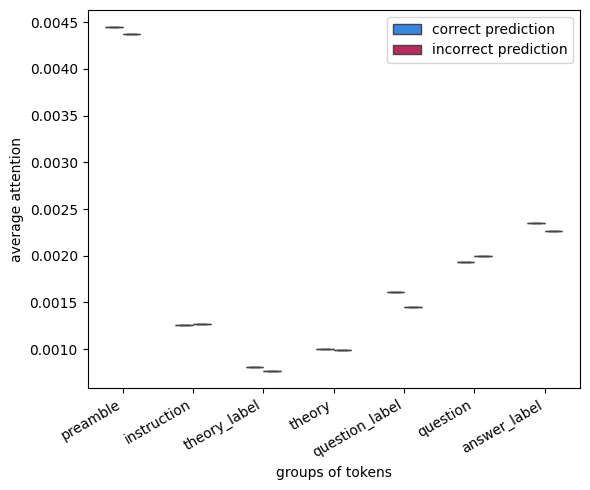

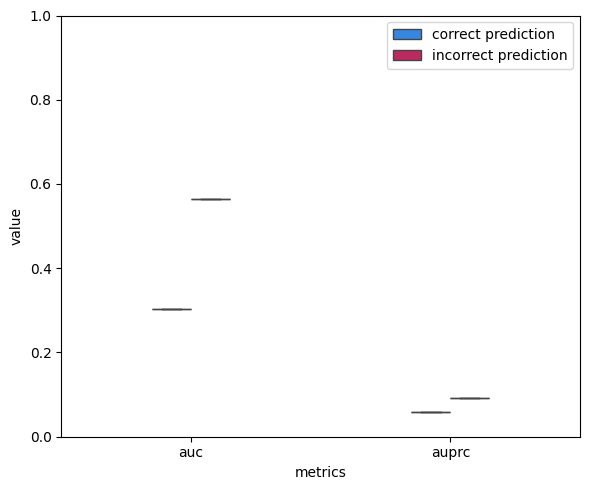

In [38]:
prompts, y_true, proofs = create_prompts(dataset, n_prompts=N_PROMPTS)
text_generation_and_attention_analysis(prompts, y_true, proofs, model, tokenizer, "zero_shot", RESULTS_FOLDER)

#### One shot

In [46]:
examples = [examples_dataset[12]] #[(i, e) for i, e in enumerate(examples_dataset) if i < 20]
prompts, y_true, proofs = create_prompts(dataset, examples, N_PROMPTS)

  0%|          | 0/2 [00:00<?, ?it/s]

[1125, 1153, 1173, 1194, 1216, 1236, 1258, 1285, 1313, 1341, 1362, 1384, 1407, 1428, 1451, 1479, 1508, 1590, 1638, 1723, 1793, 1867, 1936, 1984, 2038]
[] 313 313


/home/mazzon/Desktop/NLP/nlp_project2/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


[1125, 1153, 1173, 1194, 1216, 1236, 1258, 1285, 1313, 1341, 1362, 1384, 1407, 1428, 1451, 1479, 1508, 1590, 1638, 1723, 1793, 1867, 1936, 1984, 2038]
[] 313 313
pos ground truth: 1
neg ground truth: 1 

  accuracy: 0.5
  f1 score: 0.667
      prec: 0.5
       rec: 1.0


/home/mazzon/Desktop/NLP/nlp_project2/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


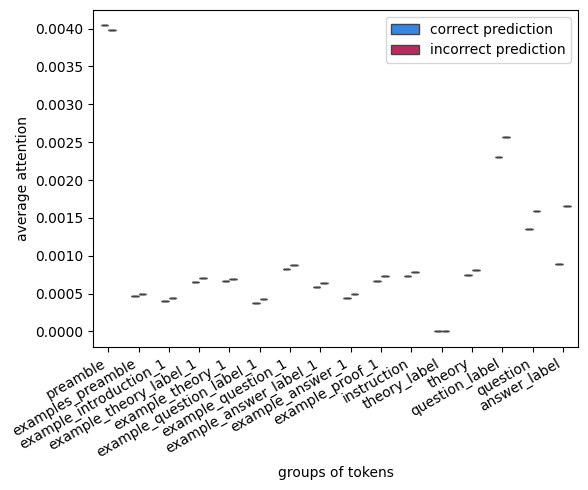

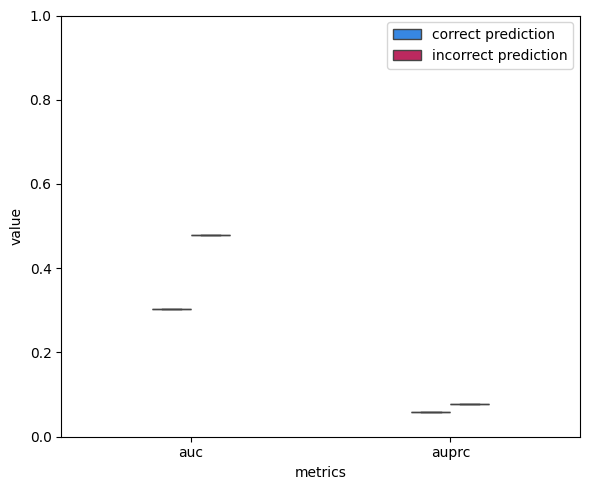

In [47]:
text_generation_and_attention_analysis(prompts, y_true, proofs, model, tokenizer, "one_shot", RESULTS_FOLDER)

#### Few shots

  0%|          | 0/10 [00:00<?, ?it/s]

pos ground truth: 5
neg ground truth: 5 

  accuracy: 0.3
  f1 score: 0.364
      prec: 0.333
       rec: 0.4


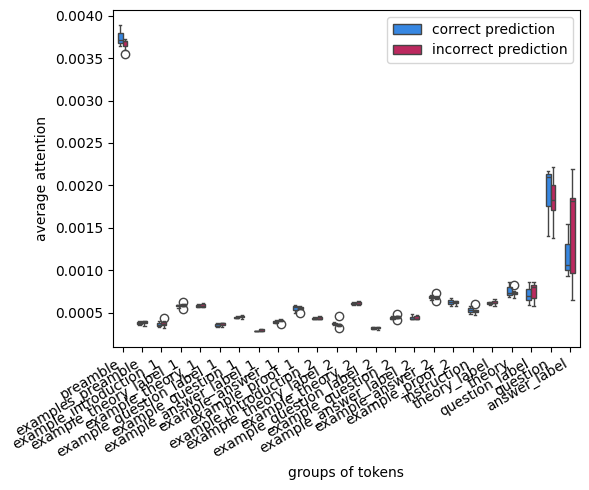

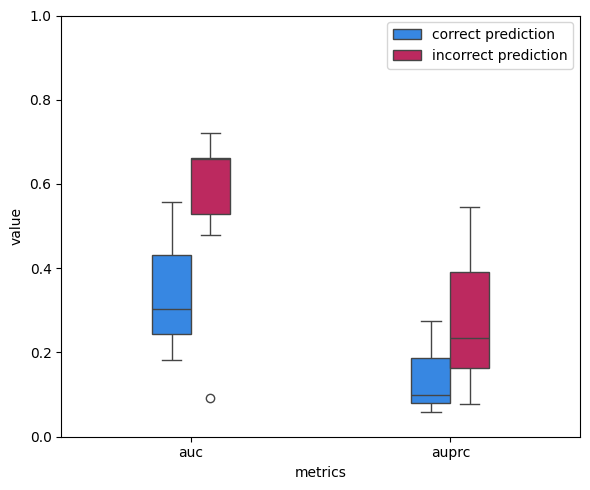

In [ ]:
examples = [examples_dataset[9], examples_dataset[12]]
text_generation_and_attention_analysis(*create_prompts(dataset, examples, N_PROMPTS), model, tokenizer, "few_shot", RESULTS_FOLDER)